# The Story of New York on Yellow Cabs

In this analysis we are going to explore yellow cab data to learn more about the patterns and behaviors of cab traffic in NYC.
  
  There are around 1.4 million trips records in the dataset covering the first half of 2016, and most important information are pickup and dropoff time & locations(geo location).
  

We will mainly focus on finding the cabs usage patterns at year level, week level and day level, and we will dig deep into the differences between weekdays and weekends.


![title](img/image1.jpg)

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import decomposition
from scipy import stats
from sklearn import cluster

matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

## Loading data, removing outliers and converting everything in to useable variables


In [3]:
taxiDB = pd.read_csv('C:/Users/hongy/Desktop/dataanalyst/data analysis project/yellow cabs/train.csv')

taxiDB.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Next, we are going to remove obvious outliers.

In [4]:
# remove obvious outliers
allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

longLimits = [np.percentile(allLong, 0.3), np.percentile(allLong, 99.7)]
latLimits  = [np.percentile(allLat , 0.3), np.percentile(allLat , 99.7)]
durLimits  = [np.percentile(taxiDB['trip_duration'], 0.4), np.percentile(taxiDB['trip_duration'], 99.7)]

taxiDB = taxiDB[(taxiDB['pickup_latitude']   >= latLimits[0] ) & (taxiDB['pickup_latitude']   <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['dropoff_latitude']  >= latLimits[0] ) & (taxiDB['dropoff_latitude']  <= latLimits[1]) ]
taxiDB = taxiDB[(taxiDB['pickup_longitude']  >= longLimits[0]) & (taxiDB['pickup_longitude']  <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['dropoff_longitude'] >= longLimits[0]) & (taxiDB['dropoff_longitude'] <= longLimits[1])]
taxiDB = taxiDB[(taxiDB['trip_duration']     >= durLimits[0] ) & (taxiDB['trip_duration']     <= durLimits[1]) ]
taxiDB = taxiDB.reset_index(drop=True)

allLat  = np.array(list(taxiDB['pickup_latitude'])  + list(taxiDB['dropoff_latitude']))
allLong = np.array(list(taxiDB['pickup_longitude']) + list(taxiDB['dropoff_longitude']))

# convert fields to sensible units
medianLat  = np.percentile(allLat,50)
medianLong = np.percentile(allLong,50)

latMultiplier  = 111.32
longMultiplier = np.cos(medianLat*(np.pi/180.0)) * 111.32

taxiDB['duration [min]'] = taxiDB['trip_duration']/60.0
taxiDB['src lat [km]']   = latMultiplier  * (taxiDB['pickup_latitude']   - medianLat)
taxiDB['src long [km]']  = longMultiplier * (taxiDB['pickup_longitude']  - medianLong)
taxiDB['dst lat [km]']   = latMultiplier  * (taxiDB['dropoff_latitude']  - medianLat)
taxiDB['dst long [km]']  = longMultiplier * (taxiDB['dropoff_longitude'] - medianLong)

allLat  = np.array(list(taxiDB['src lat [km]'])  + list(taxiDB['dst lat [km]']))
allLong = np.array(list(taxiDB['src long [km]']) + list(taxiDB['dst long [km]']))

### Plot visualization for geo locations and trip duration variables.

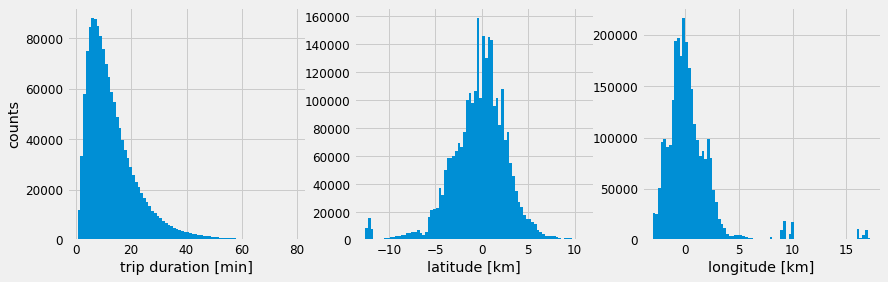

In [7]:
fig, axArray = plt.subplots(nrows=1,ncols=3,figsize=(13,4))
axArray[0].hist(taxiDB['duration [min]'],80); 
axArray[0].set_xlabel('trip duration [min]'); axArray[0].set_ylabel('counts')
axArray[1].hist(allLat ,80); axArray[1].set_xlabel('latitude [km]')
axArray[2].hist(allLong,80); axArray[2].set_xlabel('longitude [km]')

plt.show()

### Plot visualization for trip duration comparing with straight-line distance between pickup and dropoff

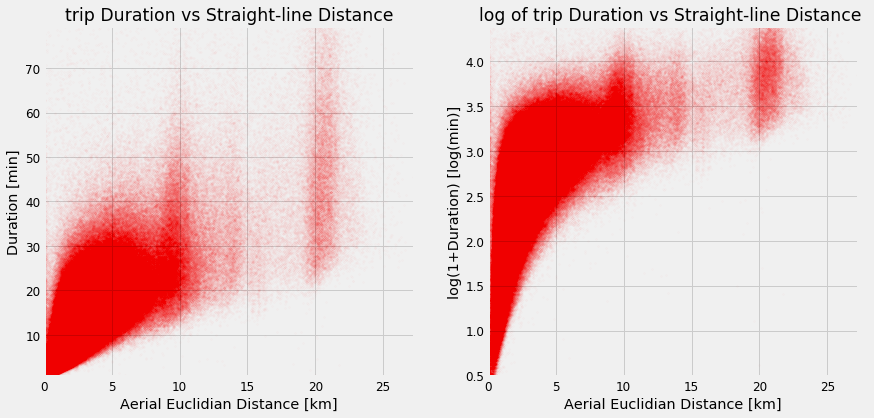

In [11]:
taxiDB['log duration']       = np.log1p(taxiDB['duration [min]'])
taxiDB['euclidian distance'] = np.sqrt((taxiDB['src lat [km]']  - taxiDB['dst lat [km]'] )**2 + 
                                       (taxiDB['src long [km]'] - taxiDB['dst long [km]'])**2)

fig, axArray = plt.subplots(nrows=1,ncols=2,figsize=(13,6))
axArray[0].scatter(taxiDB['euclidian distance'], taxiDB['duration [min]'],c='r',s=5,alpha=0.01); 
axArray[0].set_xlabel('Aerial Euclidian Distance [km]'); axArray[0].set_ylabel('Duration [min]')
axArray[0].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[0].set_ylim(taxiDB['duration [min]'].min(),taxiDB['duration [min]'].max())
axArray[0].set_title('trip Duration vs Straight-line Distance')

axArray[1].scatter(taxiDB['euclidian distance'], taxiDB['log duration'],c='r',s=5,alpha=0.01); 
axArray[1].set_xlabel('Aerial Euclidian Distance [km]'); axArray[1].set_ylabel('log(1+Duration) [log(min)]')
axArray[1].set_xlim(taxiDB['euclidian distance'].min(),taxiDB['euclidian distance'].max())
axArray[1].set_ylim(taxiDB['log duration'].min(),taxiDB['log duration'].max())
axArray[1].set_title('log of trip Duration vs Straight-line Distance ')

plt.show()

We can see that when distance is low, duration time and straight-line distance are more correlated. When the distance increase, it's hard to find a range for trip duration.

### Spatial density plot visualization of pickup and dropoff locations

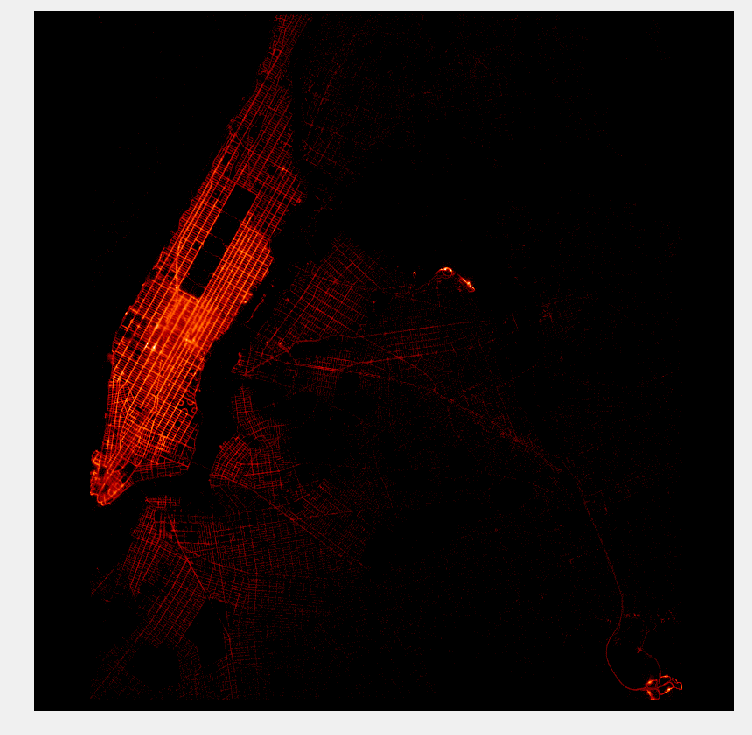

In [33]:
# show the log density of pickup and dropoff locations
imageSize = (800,800)
longRange = [-5,19]
latRange = [-13,11]

allLatInds  = imageSize[0] - (imageSize[0] * (allLat  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
allLongInds =                (imageSize[1] * (allLong - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

locationDensityImage = np.zeros(imageSize)
for latInd, longInd in zip(allLatInds,allLongInds):
    locationDensityImage[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,12))
ax.imshow(np.log(locationDensityImage+1),cmap='gist_heat')
ax.set_axis_off()

plt.show()

This is really cool visualization.  
Since every dropoff and pickup locations are on a actual street, the final plot looks like a map, and we are using our data to draw a map of NYC, without a actual map!!  
And three lightest part are Manhattan and two airports.

### Dig more into Manhattan area

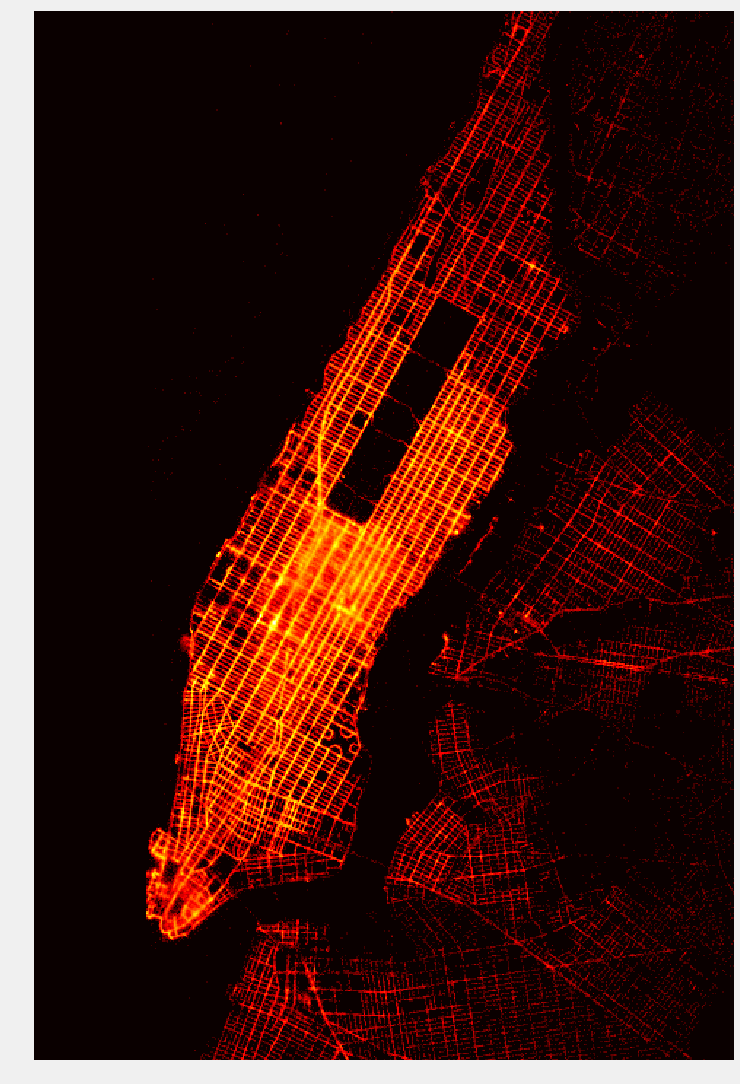

In [34]:
imageSizeMan = (720,480)
latRangeMan = [-8,10]
longRangeMan = [-5,7]

indToKeep  = np.logical_and(allLat > latRangeMan[0], allLat < latRangeMan[1])
indToKeep  = np.logical_and(indToKeep, np.logical_and(allLong > longRangeMan[0], allLong < longRangeMan[1]))
allLatMan  = allLat[indToKeep]
allLongMan = allLong[indToKeep]

allLatIndsMan  = (imageSizeMan[0]-1) - (imageSizeMan[0] * (allLatMan  - latRangeMan[0])
                                                        / (latRangeMan[1] - latRangeMan[0])).astype(int)
allLongIndsMan =                       (imageSizeMan[1] * (allLongMan - longRangeMan[0])
                                                        / (longRangeMan[1] - longRangeMan[0])).astype(int)

locationDensityImageMan = np.zeros(imageSizeMan)
for latInd, longInd in zip(allLatIndsMan,allLongIndsMan):
    locationDensityImageMan[latInd,longInd] += 1

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,18))
ax.imshow(np.log(locationDensityImageMan+1),cmap='hot')
ax.set_axis_off()

plt.show()

#### Creating some related variables for future use.

In [35]:
pickupTime = pd.to_datetime(taxiDB['pickup_datetime'])

taxiDB['src hourOfDay'] = (pickupTime.dt.hour*60.0 + pickupTime.dt.minute)   / 60.0
taxiDB['dst hourOfDay'] = taxiDB['src hourOfDay'] + taxiDB['duration [min]'] / 60.0

taxiDB['dayOfWeek']     = pickupTime.dt.weekday
taxiDB['hourOfWeek']    = taxiDB['dayOfWeek']*24.0 + taxiDB['src hourOfDay']

taxiDB['monthOfYear']   = pickupTime.dt.month
taxiDB['dayOfYear']     = pickupTime.dt.dayofyear
taxiDB['weekOfYear']    = pickupTime.dt.weekofyear
taxiDB['hourOfYear']    = taxiDB['dayOfYear']*24.0 + taxiDB['src hourOfDay']

### Clustering the trips and look at their distribution

There are 5 major attributes in one trip:
1. pickup latitude
2. pickup longitude
3. dropoff latitude
4. dropoff longitude
5. trip duration  
Let's cluster all the records to 80 stereotypical trips, and see how they are distributed, and change over time.

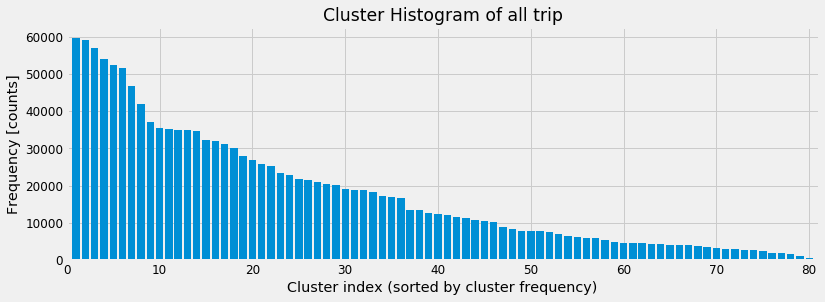

In [36]:
tripAttributes = np.array(taxiDB.loc[:,['src lat [km]','src long [km]','dst lat [km]','dst long [km]','duration [min]']])
meanTripAttr = tripAttributes.mean(axis=0)
stdTripAttr  = tripAttributes.std(axis=0)
tripAttributes = stats.zscore(tripAttributes, axis=0)

numClusters = 80
TripKmeansModel = cluster.MiniBatchKMeans(n_clusters=numClusters, batch_size=120000, n_init=100, random_state=1)
clusterInds = TripKmeansModel.fit_predict(tripAttributes)

clusterTotalCounts, _ = np.histogram(clusterInds, bins=numClusters)
sortedClusterInds = np.flipud(np.argsort(clusterTotalCounts))

plt.figure(figsize=(12,4)); plt.title('Cluster Histogram of all trip')
plt.bar(range(1,numClusters+1),clusterTotalCounts[sortedClusterInds])
plt.ylabel('Frequency [counts]'); plt.xlabel('Cluster index (sorted by cluster frequency)')
plt.xlim(0,numClusters+1)

plt.show()

### Visualize differnet types of trip on the Map
Sources: in magenta color  
Destination: in green color  
Arrow: from sources to destination

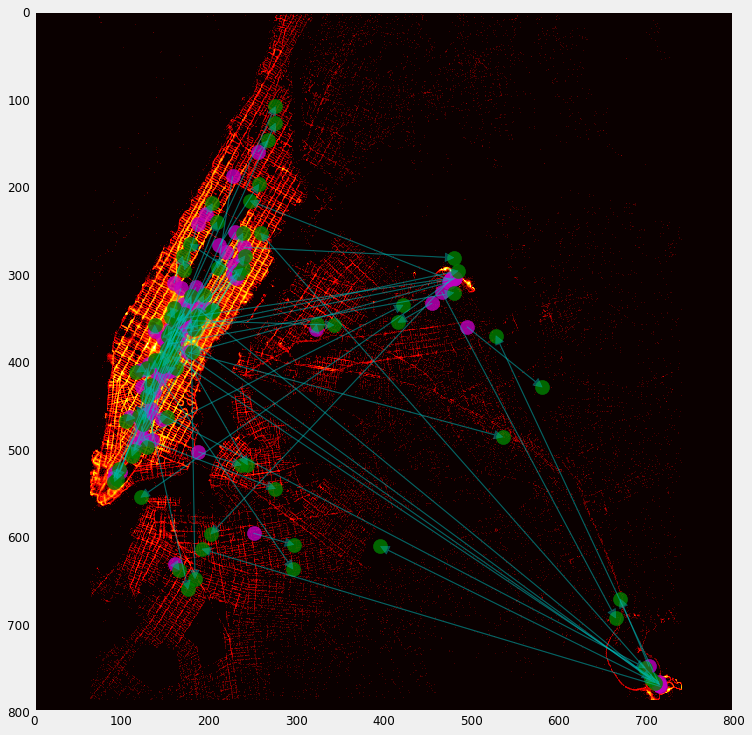

In [39]:
def ConvertToImageCoords(latCoord, longCoord, latRange, longRange, imageSize):
    latInds  = imageSize[0] - (imageSize[0] * (latCoord  - latRange[0])  / (latRange[1]  - latRange[0]) ).astype(int)
    longInds =                (imageSize[1] * (longCoord - longRange[0]) / (longRange[1] - longRange[0])).astype(int)

    return latInds, longInds

templateTrips = TripKmeansModel.cluster_centers_ * np.tile(stdTripAttr,(numClusters,1)) + np.tile(meanTripAttr,(numClusters,1))

srcCoords = templateTrips[:,:2]
dstCoords = templateTrips[:,2:4]

srcImCoords = ConvertToImageCoords(srcCoords[:,0],srcCoords[:,1], latRange, longRange, imageSize)
dstImCoords = ConvertToImageCoords(dstCoords[:,0],dstCoords[:,1], latRange, longRange, imageSize)

plt.figure(figsize=(12,12))
plt.imshow(np.log(locationDensityImage+1),cmap='hot'); plt.grid('off')
plt.scatter(srcImCoords[1],srcImCoords[0],c='m',s=200,alpha=0.8)
plt.scatter(dstImCoords[1],dstImCoords[0],c='g',s=200,alpha=0.8)

for i in range(len(srcImCoords[0])):
    plt.arrow(srcImCoords[1][i],srcImCoords[0][i], dstImCoords[1][i]-srcImCoords[1][i], dstImCoords[0][i]-srcImCoords[0][i], 
              edgecolor='c', facecolor='c', width=0.8,alpha=0.4,head_width=10.0,head_length=10.0,length_includes_head=True)

    
plt.show()

From the plot, we can figure a extreme uneven distribution of destination and sources.  
It's easy to find out, Manhattan mostly serve as destination, and the two big airport serve as both destinations and sources.  
Moreover, the other districts of NYC have lower number of destinations and sources.

## More exploration on different date patterns on taxi trips

### Hourly Trip Distributions during Weekdays
How does different type of trips change during workday?

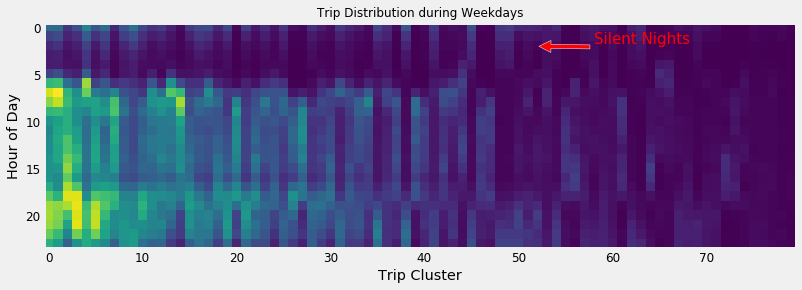

In [40]:
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekday = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] <= 4)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekday[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekdays', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekday); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Silent Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))

plt.show()

Each row contains the different trips distribution and the intensity represents trip frequency. (Dark blue means a low frequency)


We can see that around 6AM people start waking up and (most likely) heading off to work.  
There is a second surge of taxi rides at around 18:00/19:00 (6PM/7PM) which is (most likely) people getting back home.  
It's also extreemly evindent that during weedays, people are almost not active during the night. This is marked by the red arrow.

### Hourly Trip Distributions during Weekends
How does different type of trips change during weekends?

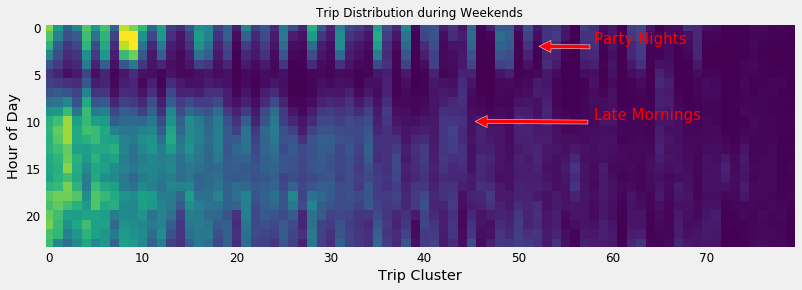

In [41]:
hoursOfDay = np.sort(taxiDB['src hourOfDay'].astype(int).unique())
clusterDistributionHourOfDay_weekend = np.zeros((len(hoursOfDay),numClusters))
for k, hour in enumerate(hoursOfDay):
    slectedInds = (taxiDB['src hourOfDay'].astype(int) == hour) & (taxiDB['dayOfWeek'] >= 5)
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionHourOfDay_weekend[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(12,6))
ax.set_title('Trip Distribution during Weekends', fontsize=12)
ax.imshow(clusterDistributionHourOfDay_weekend); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Hour of Day')
ax.annotate('Party Nights', color='r', fontsize=15, xy=(52, 2), xytext=(58, 1.75),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Late Mornings', color='r', fontsize=15, xy=(45, 10), xytext=(58, 9.75),
            arrowprops=dict(facecolor='red', shrink=0.03))

plt.show()

We can see that during weekends, people are much more active during the night, and also are starting their day much later in the day when compared to regular weekdays. The red arrows mark these two time points on the graph.

### Weekly Trip Distribution for Different days in a week
How does the trip distribution change during the week?


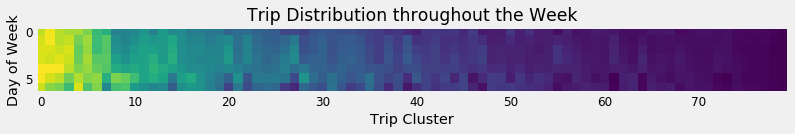

In [44]:
daysOfWeek = np.sort(taxiDB['dayOfWeek'].unique())
clusterDistributionDayOfWeek = np.zeros((len(daysOfWeek),numClusters))
for k, day in enumerate(daysOfWeek):
    slectedInds = taxiDB['dayOfWeek'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfWeek[k,:] = currDistribution[sortedClusterInds]

plt.figure(figsize=(12,5)); plt.title('Trip Distribution throughout the Week')
plt.imshow(clusterDistributionDayOfWeek); plt.grid('off')
plt.xlabel('Trip Cluster'); plt.ylabel('Day of Week')

plt.show()

Here is a relection of what we have observed from the previous two plots, that during weekends, the pattern of trip distributions is somewhat different than that during the weekday.

### Yearly Trip Distribution for different days in the year
How does the trip distribution change during one year?



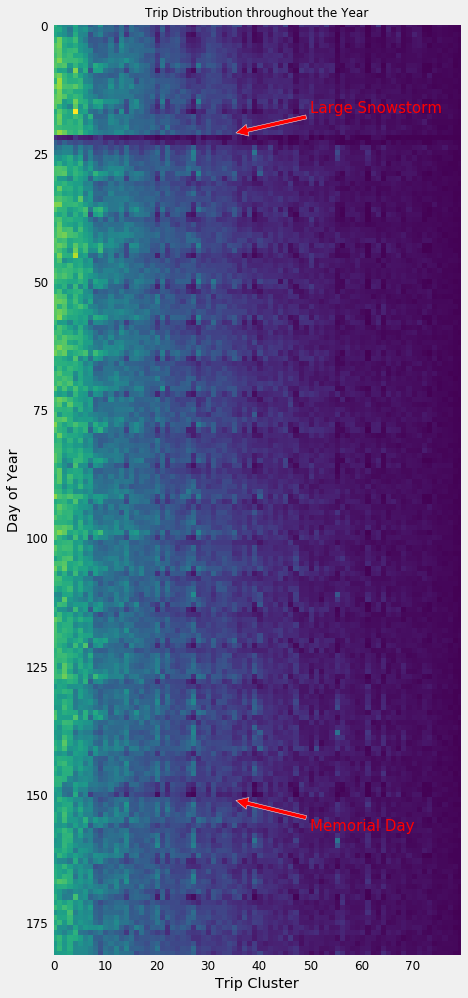

In [45]:
daysOfYear = taxiDB['dayOfYear'].unique()
daysOfYear = np.sort(daysOfYear)
clusterDistributionDayOfYear = np.zeros((len(daysOfYear),numClusters))
for k, day in enumerate(daysOfYear):
    slectedInds = taxiDB['dayOfYear'] == day
    currDistribution, _ = np.histogram(clusterInds[slectedInds], bins=numClusters)
    clusterDistributionDayOfYear[k,:] = currDistribution[sortedClusterInds]

fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,16))
ax.set_title('Trip Distribution throughout the Year', fontsize=12)
ax.imshow(clusterDistributionDayOfYear); ax.grid('off')
ax.set_xlabel('Trip Cluster'); ax.set_ylabel('Day of Year')
ax.annotate('Large Snowstorm', color='r', fontsize=15 ,xy=(35, 21), xytext=(50, 17),
            arrowprops=dict(facecolor='red', shrink=0.03))
ax.annotate('Memorial Day', color='r', fontsize=15, xy=(35, 151), xytext=(50, 157),
            arrowprops=dict(facecolor='red', shrink=0.03))

plt.show()

The most obvious pattern here is the periodicity. We can also see two large drops of activity in the data, one around day 20-25 (end of January), and the other around 145-150 (end of May). It turns out that at the end of January there was a large snow storm in NYC, and that in the end of May there is a Memorial Day in the US. These are marked with red arrows.